In [2]:
import PyPDF2
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

<h3>Text extraction and Preprocessing</h3>

In [3]:
def extract_text_from_pdf(pdf_paths):
    text = ""
    for path in pdf_paths:
        with open(path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                text += page.extract_text() + "\n"
    return text

def clean_text(text):
    text = text.lower()   
    text = re.sub(r'(?<![a-zA-Z0-9])[^a-zA-Z0-9]+(?![a-zA-Z0-9])', '', text)
    
    return text
#If you want to add more pdf text data, do it here:
pdf_paths = ["text_data/Fundamentals of a healthy and sustainable diet.pdf", "text_data/Essentials of Healthy Eating.pdf", "text_data/Dietary_Guidelines_for_Americans_2020-2025.pdf"]
raw_text = extract_text_from_pdf(pdf_paths)

#get the web scrapped text data here
text_file = open("webtext.txt", "r")
webtext = text_file.read()
raw_text += webtext


raw_text = clean_text(raw_text)

raw_text = raw_text.replace('\n', '')
raw_text = re.split(r'(?<=[.!?]) +', raw_text)




<h3>Tokenize the words</h3>
<p>Note: Its worth it to try and write our own tokenizer</p>

In [4]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(raw_text)
word_counts = tokenizer.word_counts
words = 5000
rare_words = [word for word, count in word_counts.items() if count == 1]


print(words)


5000


<h3>Create N-gram sequences and input/output sequences</h3>

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

inputs = []
for line in raw_text:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram = token_list[:i+1]
        inputs.append(n_gram)

max_sequence_len = 25 
print(max_sequence_len)
inputs = np.array(pad_sequences(inputs, maxlen=max_sequence_len, padding='pre'))


display(inputs)
X = inputs[:, :-1]
y = inputs[:, -1]





25


array([[   0,    0,    0, ...,    0, 2291,  512],
       [   0,    0,    0, ..., 2291,  512, 2034],
       [   0,    0,    0, ...,  512, 2034, 4611],
       ...,
       [   0,    0,    0, ...,  421,  456, 1123],
       [   0,    0,    0, ...,  456, 1123,    1],
       [   0,    0,    0, ..., 1123,    1, 1105]], dtype=int32)

<h3>Define the model</h3>

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(words, 100, input_length=max_sequence_len-1))  
model.add(LSTM(150, return_sequences=False))  
model.add(Dropout(0.2))  # small dropout to prevent overfitting
model.add(Dense(words, activation='softmax'))
model.build(input_shape=(None, max_sequence_len-1))
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 24, 100)        │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5000)           │       755,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,405,600 (5.36 MB)

 Trainable params: 1,405,600 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

None


<h3>Train the model</h3>

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)


model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)

history = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  batch_size=32, #you can up this number to 168 will add a boost in training time, but drop in accuracy
  epochs=50, # If youre adding more text data, good idea to start w lower number to see how effecieint it is training 
  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)] 
)

Epoch 1/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - accuracy: 0.0471 - loss: 6.7991 - val_accuracy: 0.1156 - val_loss: 5.9193
Epoch 2/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - accuracy: 0.1401 - loss: 5.6050 - val_accuracy: 0.2047 - val_loss: 5.2028
Epoch 3/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 70s 24ms/step - accuracy: 0.2243 - loss: 4.8297 - val_accuracy: 0.2605 - val_loss: 4.7997
Epoch 4/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 63s 22ms/step - accuracy: 0.2795 - loss: 4.2798 - val_accuracy: 0.2851 - val_loss: 4.5797
Epoch 5/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 67s 23ms/step - accuracy: 0.3158 - loss: 3.8801 - val_accuracy: 0.3084 - val_loss: 4.4511
Epoch 6/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - accuracy: 0.3517 - loss: 3.5498 - val_accuracy: 0.3193 - val_loss: 4.3870
Epoch 7/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 64s 22ms/step - accuracy: 0.3827 - loss: 3.2723 - val_accuracy: 0.3304 - val_loss: 4.3378
Epoch 8/50
2929/2929 ━━━━━━━━━━━━━━━━━━━━ 72s 25ms/step - accuracy: 0.4084 -

<h3>Plot the metrics</h3>
<h>The goal here is to keep the Validatin Accuracy close to the Training accuracy so that model doesnt underfit aka just perform well on the training data and bad on any unknown data</h>

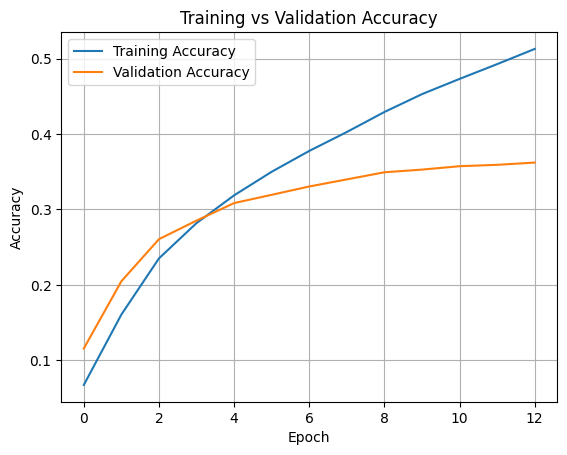

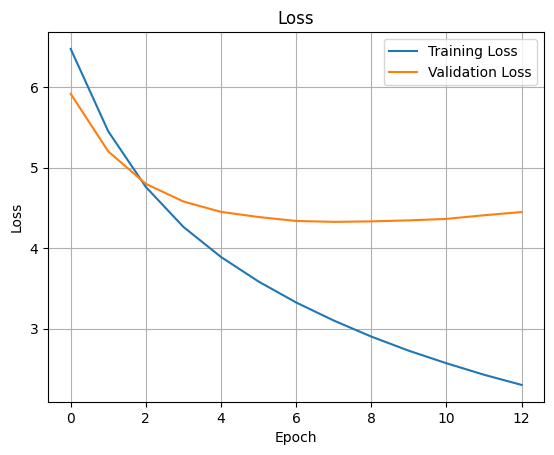

In [10]:
import matplotlib.pyplot as plt
history = model.history
plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

<h3>Save and test the model</h3>

In [44]:
import pickle

#NOTE*: to save the model so you dont have to retrain , remember to uncomment here and save it , make sure you change the name
# pickle is how you save the tokenizer so that the model can utilize it in future use
# Example of how to load it up is in TestingModel.ipynb
#*-----------------UNCOMMENT ONCE TRAINING IS DONE---------------*
model.save('nutri_model_v1.keras')

with open('nutri_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

seed_texts = ["In order to eat a healthy diet you must", 
              "Good sources of fiber include",
              "A balanced diet",
              "To lose weight",
              "Increased sodium intake can"
             ]


next_words = 4

for seed_text in seed_texts:
    print("INPUT SENTENCE: " , seed_text)
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        
        seed_text += " " + output_word


    print("NEXT PREDICTED WORDS:", seed_text)
    print("")

INPUT SENTENCE:  In order to eat a healthy diet you must
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
NEXT PREDICTED WORDS: In order to eat a healthy diet you must need to lose weight

INPUT SENTENCE:  Good sources of fiber include
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
NEXT PREDICTED WORDS: Good sources of fiber include a variety of nutrients

INPUT SENTENCE:  A balanced diet
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NEXT PREDICTED WORDS: A balanced diet is a healthy dietary

INPUT SENTENCE:  To lose weight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
NEXT

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
